In [570]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

In [571]:
# Physical parameters
delta = 0.1 # Energy gap
alpha = 0.5
tau = 1 # total time evolution
temperature = 500 # Changes p_0

# Formatting parameters
amt_times = 100 # How many points we calculate
interval_colunas = 10 # Int interval between columns shown in work distr
width = depth = 0.02 # Size of the columns

# Fixed parameters
t_0 = 0
step = 1/amt_times

In [572]:
def g_t(t):
  return alpha - t / tau
  ### Defines the protocol

def A(t):
    return g_t(t)

def B(t):
    return delta

def CalcDerivative():
    t = sp.symbols('t')
    dg_dt = sp.diff(A(t),t)
    return sp.lambdify(t, dg_dt)

dg_dt = CalcDerivative()

def C(t):
    return - delta * dg_dt(t) /(2* (delta**2 + (A(t))**2))

##Energy levels

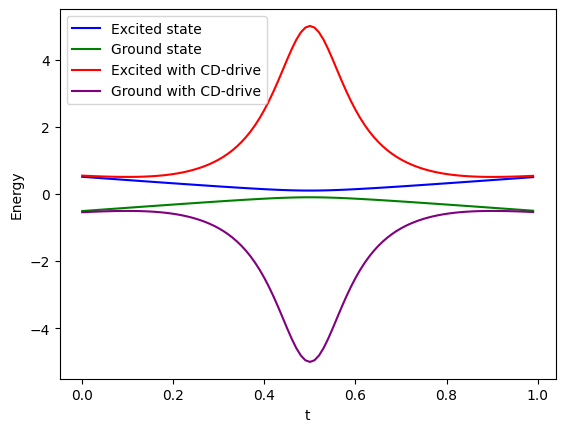

In [573]:
def e1(t):
  return (delta**2 + g_t(t)**2 )**(1/2)

def e2(t):
  return -(delta**2 + g_t(t)**2 )**(1/2)

def e1_cd(t):
  return (4*(g_t(t)**2 + delta**2 )**3 + delta**2 * (dg_dt(t))**2 )**(1/2) / (2 * (delta**2 + (g_t(t))**2))

def e2_cd(t):
  return -(4*((g_t(t))**2 + delta**2 )**3 + delta**2 * dg_dt(t)**2 )**(1/2) / (2 * (delta**2 + (g_t(t))**2))

p_e1 = []
p_e2 = []
p_e1_cd = []
p_e2_cd = []
val_g_t = []
time = []

for i in np.arange(t_0, tau, step):
  p_e1 += [e1(i)]
  p_e2 += [e2(i)]
  p_e1_cd += [e1_cd(i)]
  p_e2_cd += [e2_cd(i)]
  val_g_t += [g_t(i)]
  time += [i]

plt.plot(time, p_e1, color="blue", label="Excited state")
plt.plot(time, p_e2, color="green", label="Ground state")
plt.plot(time, p_e1_cd, color="red", label="Excited with CD-drive")
plt.plot(time, p_e2_cd, color="purple", label="Ground with CD-drive")

plt.legend()
plt.xlabel('t')
plt.ylabel('Energy')

plt.show()

## Work distribution

In [574]:
# Initial conditions
y0 = [0, 0, 0]

# Time interval for solution
t_span = (0, tau)

t_eval = np.linspace(0, tau, amt_times)

###Work distribution without CD

In [575]:
# Defining the ODEs system
def system(t, y):
    alpha, beta, gamma = y
    d_alpha_dt = -A(t) * np.cos(2 * alpha) * np.tan(2 * beta) - B(t)
    d_beta_dt = A(t) * np.sin(2 * alpha)
    d_gamma_dt = -A(t) * np.cos(2 * alpha) / np.cos(2 * beta)
    return [d_alpha_dt, d_beta_dt, d_gamma_dt]

# Solving the ODE system
sol = solve_ivp(system, t_span, y0, t_eval=t_eval, method='DOP853')
alpha_solved = sol.y[0]
beta_solved = sol.y[1]
gamma_solved = sol.y[2]

# Calculating the evolution operator

evol_total = []

for varaux in range(amt_times):
  exp_alpha = np.array([[np.cos(alpha_solved[varaux]), 1j * np.sin(alpha_solved[varaux])],
                        [1j * np.sin(alpha_solved[varaux]) , np.cos(alpha_solved[varaux])]])
  exp_beta = np.array([[np.cos(beta_solved[varaux]), np.sin(beta_solved[varaux])],
                       [-np.sin(beta_solved[varaux]), np.cos(beta_solved[varaux])]])
  exp_gamma = np.array([[np.exp(1j * gamma_solved[varaux]) , 0],
                        [0 , np.exp(-1j * gamma_solved[varaux])]])
  evol_total += [np.linalg.multi_dot([exp_alpha, exp_beta, exp_gamma])]

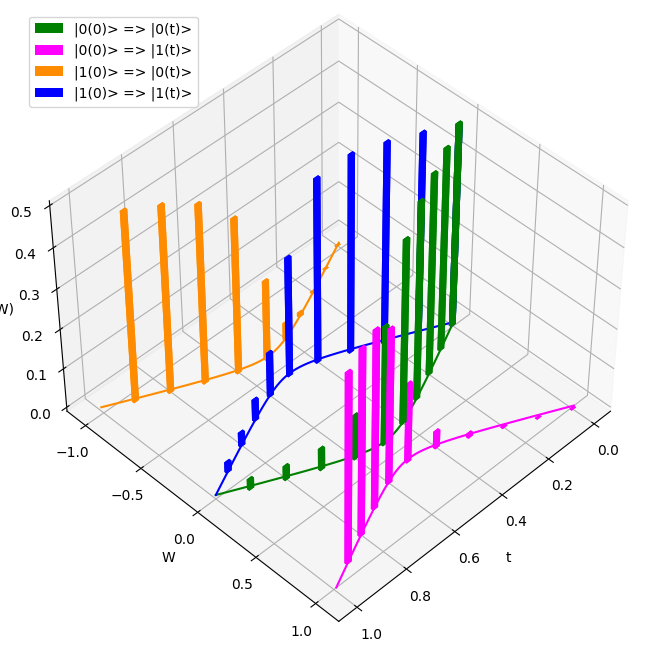

In [576]:
def ground_state(t):
  return (np.array([ B(t) , -A(t) + np.sqrt(B(t)**2 + A(t)**2) ])/np.sqrt(2 * (B(t)**2 + A(t)**2) - 2 * A(t) * np.sqrt(B(t)**2 + A(t)**2) ))

def excited_state(t):
  return (np.array([ -A(t) + np.sqrt(B(t)**2 + A(t)**2) , -B(t) ])/np.sqrt(2 * (B(t)**2 + A(t)**2) - 2 * A(t) * np.sqrt(B(t)**2 + A(t)**2) ))

def en_ground_excited_state(t,state):
  ### 0=ground e 1=excited
  return (-1)**(state+1) * np.sqrt(B(t)**2 + A(t)**2)

def p0(temp):
  if temp<0.0006: # Arbitrarily low temperature
    return (np.array([ 1 , 0 ]))
  else:
    return (np.array([ np.exp(-en_ground_excited_state(0,0)/(temp)) , np.exp(-en_ground_excited_state(0,1)/(temp)) ])
              /(np.exp(-en_ground_excited_state(0, 0)/(temp)) + np.exp(-en_ground_excited_state(0, 1)/(temp))))

def p_n_m(t):
  conjaux_t = [ground_state(t), excited_state(t)]
  conjaux_0 = [ground_state(0), excited_state(0)]
  varaux = []
  for i in conjaux_t:
    for j in conjaux_0:
      varaux += [np.linalg.norm(np.linalg.multi_dot([i, evol_total[int(t * amt_times / tau)],j]))**2]
  return varaux

points_no_cd = []

for t in np.linspace(0, tau - tau/amt_times, amt_times):
  coord_energ = []
  probabilities = []

  for i in range(2):
    for j in range(2):
      if i==0:
        prob = p0(temperature)[i] * p_n_m(t)[2*j]
        ponto = [en_ground_excited_state(t,j)-en_ground_excited_state(0,i), prob]
      elif i==1:
        prob = p0(temperature)[i] * p_n_m(t)[2*j+1]
        ponto = [en_ground_excited_state(t,j)-en_ground_excited_state(0,i), prob]

      coord_energ += [ponto[0]]
      probabilities += [ponto[1]]
  points_no_cd += [[t, [coord_energ, probabilities]]]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Adicionando points to the graphic
colors = ['green', 'fuchsia', 'darkorange', 'blue']

for i in range(0, len(points_no_cd), interval_colunas):
    for yi, color, height in zip(points_no_cd[i][1][0], colors, points_no_cd[i][1][1]):
        ax.bar3d(points_no_cd[i][0], yi, 0, width, depth, height, color=color, shade=False)

# Axes label
ax.set_xlabel('t')
ax.set_ylabel('W')
ax.set_zlabel('P(W)')

# Legend
legend_elements = [Patch(facecolor='green', label='|0(0)> => |0(t)>'),
                   Patch(facecolor='fuchsia', label='|0(0)> => |1(t)>'),
                   Patch(facecolor='darkorange', label='|1(0)> => |0(t)>'),
                   Patch(facecolor='blue', label='|1(0)> => |1(t)>')]
ax.legend(handles=legend_elements, loc='upper left')

ax.plot(t_eval, en_ground_excited_state(t_eval,0) - en_ground_excited_state(0,0) , zs=0, zdir='z', color='green')
ax.plot(t_eval, en_ground_excited_state(t_eval,1) - en_ground_excited_state(0,1) , zs=0, zdir='z', color='blue')
ax.plot(t_eval, en_ground_excited_state(t_eval,0) - en_ground_excited_state(0,1) , zs=0, zdir='z', color='darkorange')
ax.plot(t_eval, en_ground_excited_state(t_eval,1) - en_ground_excited_state(0,0) , zs=0, zdir='z', color='fuchsia')

ax.view_init(45, 45) # View angle
plt.show()

###Work distribution with CD

In [577]:
# Defining the ODEs system
def system_cd(t, y):
    alpha, beta, gamma = y
    d_alpha_dt = -A(t) * np.cos(2 * alpha) * np.tan(2 * beta) - C(t) * np.sin(2 * alpha) * np.tan(2 * beta) - B(t)
    d_beta_dt = A(t) * np.sin(2 * alpha) - C(t) * np.cos(2 * alpha)
    d_gamma_dt = -A(t) * np.cos(2 * alpha) / np.cos(2 * beta) - C(t) * np.sin(2 * alpha) / np.cos(2 * beta)
    return [d_alpha_dt, d_beta_dt, d_gamma_dt]

# Solving the ODEs system
sol_cd = solve_ivp(system_cd, t_span, y0, t_eval=t_eval, method='DOP853')
alpha_solved_cd = sol_cd.y[0]
beta_solved_cd = sol_cd.y[1]
gamma_solved_cd = sol_cd.y[2]

# Calculating the evolution operator

evol_total_cd = []

for varaux in range(amt_times):
  exp_alpha = np.array([[np.cos(alpha_solved_cd[varaux]), 1j * np.sin(alpha_solved_cd[varaux])],
                        [1j * np.sin(alpha_solved_cd[varaux]) , np.cos(alpha_solved_cd[varaux])]])
  exp_beta = np.array([[np.cos(beta_solved_cd[varaux]), np.sin(beta_solved_cd[varaux])],
                       [-np.sin(beta_solved_cd[varaux]), np.cos(beta_solved_cd[varaux])]])
  exp_gamma = np.array([[np.exp(1j * gamma_solved_cd[varaux]) , 0],
                        [0 , np.exp(-1j * gamma_solved_cd[varaux])]])
  evol_total_cd += [np.linalg.multi_dot([exp_alpha, exp_beta, exp_gamma])]

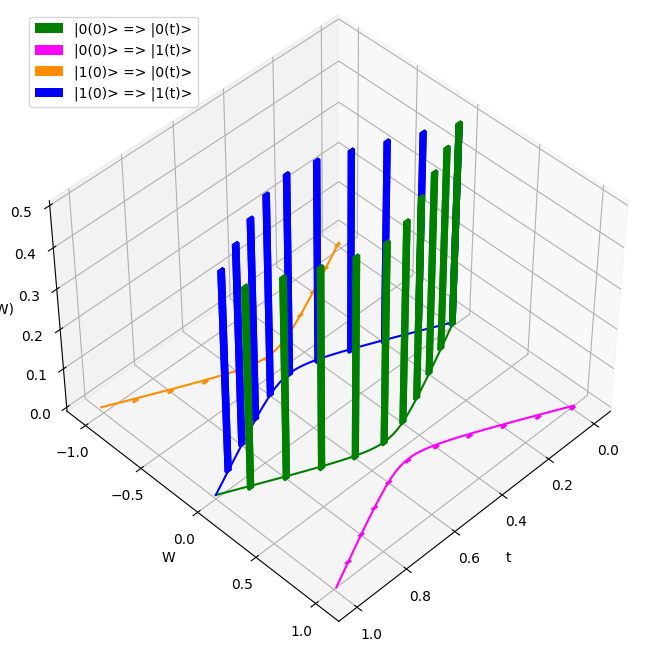

In [578]:
def aux_gamma_pm(t, state):
  ###0=ground, 1=excited
  return np.sqrt(1 + np.linalg.norm((A(t) + (-1)**(state+1) * np.sqrt(A(t)**2 + B(t)**2 + C(t)**2))/(B(t) + 1j * C(t)))**2)

def ground_state_cd(t):
  return (np.array([((A(t) - np.sqrt( A(t)**2 + B(t)**2 + C(t)**2 )) / (B(t) + 1j * C(t))), 1])/aux_gamma_pm(t,0))

def excited_state_cd(t):
  return (np.array([((A(t) + np.sqrt(A(t)**2 + B(t)**2 + C(t)**2))/(B(t) + 1j * C(t))), 1])/aux_gamma_pm(t,1))

def en_ground_excited_state_cd(t,state):
  ###0=ground, 1=excited
  return (-1)**(state+1) * np.sqrt(B(t)**2 + A(t)**2 + C(t)**2)

def p0_cd(temp):
  if temp<0.0006: #Arbitrarily low temperature
    return (np.array([ 1 , 0 ]))
  else:
    return (np.array([ np.exp(-en_ground_excited_state_cd(0,0)/(temp)) , np.exp(-en_ground_excited_state_cd(0,1)/(temp)) ])
              /(np.exp(-en_ground_excited_state_cd(0, 0)/(temp)) + np.exp(-en_ground_excited_state_cd(0, 1)/(temp))))

def p_n_m_cd(t):
  conjaux_t = [ground_state(t), excited_state(t)]
  conjaux_0 = [ground_state(0), excited_state(0)]
  varaux = []
  for i in conjaux_t:
    for j in conjaux_0:
      varaux += [np.linalg.norm(np.linalg.multi_dot([i, evol_total_cd[int(t * amt_times / tau)],j]))**2]
  return varaux

points_cd = []

for t in np.linspace(0, tau - tau/amt_times, amt_times):
  coord_energ = []
  probabilities = []

  for i in range(2):
    for j in range(2):
      if i==0:
        prob = p0_cd(temperature)[i] * p_n_m_cd(t)[2*j]
        ponto = [en_ground_excited_state(t,j)-en_ground_excited_state(0,i), prob]
      elif i==1:
        prob = p0_cd(temperature)[i] * p_n_m_cd(t)[2*j+1]
        ponto = [en_ground_excited_state(t,j)-en_ground_excited_state(0,i), prob]


      coord_energ += [ponto[0]]
      probabilities += [ponto[1]]
  points_cd += [[t, [coord_energ, probabilities]]]


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Adding points to graphic
colors = ['green', 'fuchsia', 'darkorange', 'blue']

for i in range(0, len(points_cd), interval_colunas):
    for yi, color, height in zip(points_cd[i][1][0], colors, points_cd[i][1][1]):
        ax.bar3d(points_cd[i][0], yi, 0, width, depth, height, color=color, shade=False)

# Axes label
ax.set_xlabel('t')
ax.set_ylabel('W')
ax.set_zlabel('P(W)')

# Legend
legend_elements = [Patch(facecolor='green', label='|0(0)> => |0(t)>'),
                   Patch(facecolor='fuchsia', label='|0(0)> => |1(t)>'),
                   Patch(facecolor='darkorange', label='|1(0)> => |0(t)>'),
                   Patch(facecolor='blue', label='|1(0)> => |1(t)>')]
ax.legend(handles=legend_elements, loc='upper left')

ax.plot(t_eval, en_ground_excited_state(t_eval,0) - en_ground_excited_state(0,0) , zs=0, zdir='z', color='green')
ax.plot(t_eval, en_ground_excited_state(t_eval,1) - en_ground_excited_state(0,1) , zs=0, zdir='z', color='blue')
ax.plot(t_eval, en_ground_excited_state(t_eval,0) - en_ground_excited_state(0,1) , zs=0, zdir='z', color='darkorange')
ax.plot(t_eval, en_ground_excited_state(t_eval,1) - en_ground_excited_state(0,0) , zs=0, zdir='z', color='fuchsia')

ax.view_init(45, 45) # View angle
plt.show()